<hr size="5" />

### **<font color='DarkCyan'>Salzburg University of Applied Sciences - 2023**  
#### **<font color='DarkCyan'>Information Technology & Systems Engineering**

# **<font color='GoldenRod'>Master Thesis**  
## **<font color='GoldenRod'>Deep Learning for Advancing Animal Breeding: A Study on Austrian Fleckvieh Cattle**

<hr size="5">

#### Student Name: Jakob Ganitzer
#### Degree Program:  ITSM-B

<hr size="5" />

### Imports

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import pearsonr
import seaborn as sns
from models.graphsage import SAGE_OneHot_MLP
from torch_geometric.loader import NeighborLoader
import copy
from sklearn.metrics import mean_squared_error 
import cairosvg

In [2]:
criterion = nn.MSELoss()

### Load Data

In [3]:
dataRoot = "/data"
wandbDir = "/data"
eval_dataframes = '/eval_dataframes/graphSage/'

In [4]:
heritability = "/h40"
phenotype_path = dataRoot + heritability + heritability + "_simu.dat"
snp_path = dataRoot + heritability + heritability + "_simu.snp"
benchmark_path = dataRoot + heritability + heritability + "_simu.bv"
pedigree_path = dataRoot + heritability + heritability + "_simu.ped"
snpPos_path = dataRoot + heritability + heritability + "_simu_snp.txt"
qtl_path = dataRoot + heritability + heritability + "_simu_qtl.txt"

X_path = "/test/snp_X_test_01_maf_one_hot.parquet"
y_path = "/test/snp_y_test_01_maf_one_hot.parquet"

In [5]:
checkpointRoot = '/data/checkpoints/'

In [6]:
modelName = '_'

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

In [8]:
def loadAndCheckModel():
    # Load the saved checkpoint
    checkpoint = torch.load(checkpointRoot + modelName + '/best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

In [9]:
def createDataframeAndSave(inference_df, df_pooled_output, hasId = True):
    combined_df = pd.concat([inference_df, df_pooled_output], axis=1)
    if hasId == True : combined_df['id'] = combined_df['id'].astype(int)
    combined_df.to_parquet(dataRoot + heritability + eval_dataframes + modelName + '.parquet')

In [10]:
def calcMetrics(output, targets):
    mse = mean_squared_error(targets, output)
    mae = mean_absolute_error(targets, output)
    r2 = r2_score(targets, output)
    _pearsonr, _pvalue = pearsonr(targets, output)

    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((targets- output) / targets)) * 100
    mbe = np.mean(targets - output)
    
    print("MSE:", mse)
    print("Mean Absolute Error:", mae)
    print("R2 Score:", r2)
    print("Pearson Correlation Coefficient:", _pearsonr)
    print("p-value:", _pvalue)
    print("rmse:", rmse)
    print("mape:", mape)
    print("mbe:", mbe)

In [11]:
data = ['ModelName','MSE', 'MAE', 'R2', 'PearsonR']
df_metrics = pd.DataFrame(columns = data)

def calcMetricsStore(output, targets, modelName):
    mse = mean_squared_error(targets, output)
    mae = mean_absolute_error(targets, output)
    r2 = r2_score(targets, output)
    _pearsonr, _pvalue = pearsonr(targets, output)

    # Calculate additional metrics if needed
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((targets - output) / targets)) * 100
    mbe = np.mean(targets - output)

    new_data = {
        'ModelName': modelName,
        'MSE': mse,
        'MAE': mae,
        'R2': r2,
        'PearsonR': _pearsonr,
    }

    df = pd.DataFrame([new_data])

    return df

In [12]:
def stratifiedMetrics(output, targets, num_bins=3):
    # Determine bin edges
    bin_edges = np.linspace(min(targets), max(targets), num_bins+1)
    
    for i in range(num_bins):
        # Select data within the bin
        mask = (targets >= bin_edges[i]) & (targets < bin_edges[i+1])
        targets_bin = targets[mask]
        output_bin = output[mask]
        
        bin_range = f"{bin_edges[i]} - {bin_edges[i+1]}"
        print(f"\nValue Range for Bin {i+1}: {bin_range}")

        mae = mean_absolute_error(targets_bin, output_bin)
        
        print("Mean Absolute Error:", mae)

In [13]:
def createScatterPlot(inference_df, imageName):
    # Show correlation between phenotypes

    fig, ax = plt.subplots(figsize=(5, 5)) 

    # Add trendline
    sns.regplot(data=inference_df, x="output", y="targets", ax=ax, color='darkblue',line_kws={"color": "red"}, scatter = True, scatter_kws={'s':3, 'rasterized': True})

    # Calculate slope and intercept
    slope, intercept = np.polyfit(inference_df["output"], inference_df["targets"], 1)
    line = f"TBV = {intercept:.4f} + {slope:.4f} x EBV"  # Equation of the line

    # Plot slope and intercept
    ax.text(0.05, 0.90, line, transform=ax.transAxes, va="top", fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    ax.axline((9.8, 9.8), slope=1, color='black', linestyle='--') 
    # Set axis labels
    
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlabel("EBV", fontsize=12)
    ax.set_ylabel("TBV", fontsize=12)
    #ax.set_title('Correlation Plot',  fontsize=14)
    
    ax.set_xlim(9.5, 16.5)  # Set maximum x-axis value to 17
    ax.set_ylim(9.5, 16.5)  # Set maximum y-axis value to 17
    
    
    plt.savefig('images/corr_' + imageName + '.png')
    plt.savefig('images/corr_' + imageName + '.svg', format='svg', dpi=300)
    cairosvg.svg2pdf(url='images/corr_' + imageName + '.svg', write_to='images/corr_' + imageName + '.pdf')
    plt.savefig('images/corr_' + imageName + '.eps', format='eps')
    
    plt.show()  # Display the plot


In [14]:
def loadEvalData(modelName):
    model_data = pd.read_parquet(dataRoot + heritability + eval_dataframes + modelName + '.parquet', engine='pyarrow')
    output_data = model_data['output'].values.astype(float)
    target_data = model_data['targets'].values.astype(float)

    output = torch.Tensor(output_data)
    targets = torch.Tensor(target_data)
    return model_data[['output', 'targets']],output_data, target_data, model_data

In [15]:
sns.set_style("darkgrid")
sns.set_context("paper")

def plot_histograms(output, targets, imageName):
    # Create subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Plot histograms using sns.histplot
    sns.histplot(output, ax=axs[0], kde=True)
    sns.histplot(targets, ax=axs[1], color='mediumseagreen', kde=True)

    # Calculate mean and standard deviation
    output_mean = np.mean(output)
    output_std = np.std(output)
    targets_mean = np.mean(targets)
    targets_std = np.std(targets)

    # Add mean and standard deviation as text annotations
    axs[0].text(0.05, 0.9, f'Mean: {output_mean:.2f}\nSD: {output_std:.2f}', transform=axs[0].transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    axs[1].text(0.05, 0.9, f'Mean: {targets_mean:.2f}\nSD: {targets_std:.2f}', transform=axs[1].transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    # Add lines for mean
    axs[0].axvline(output_mean, color='red', linestyle='dashed', linewidth=1)
    axs[1].axvline(targets_mean, color='red', linestyle='dashed', linewidth=1)

    # Overlay histograms using Seaborn
    sns.histplot(output, ax=axs[2],  kde=True, label='EBV', element='step')
    sns.histplot(targets, ax=axs[2], color='mediumseagreen', kde=True, label='TBV', element='step')

    # Add labels and titles
    axs[0].tick_params(axis='both', which='major', labelsize=12) 
    axs[0].set_xlabel('Estimated Breeding Values', fontsize=14) 
    axs[0].set_ylabel('Count', fontsize=14)
    axs[0].set_title('EBV Distribution', fontsize=16)  

    axs[1].tick_params(axis='both', which='major', labelsize=12) 
    axs[1].set_xlabel('True Breeding Values', fontsize=14)
    axs[1].set_ylabel('Count', fontsize=14)
    axs[1].set_title('TBV Distribution', fontsize=16)

    axs[2].tick_params(axis='both', which='major', labelsize=12) 
    axs[2].set_xlabel('Values', fontsize=14)
    axs[2].set_ylabel('Count', fontsize=14)
    axs[2].set_title('Overlayed EBV and TBV Distributions', fontsize=16)

    axs[2].legend()

    plt.tight_layout()
    plt.savefig('images/dist_' + imageName + '.png')
    plt.savefig('images/dist_' + imageName + '.svg', format='svg', dpi=300)
    cairosvg.svg2pdf(url='images/dist_' + imageName + '.svg', write_to='images/dist_' + imageName + '.pdf')
    plt.savefig('images/dist_' + imageName + '.eps', format='eps')
    plt.show()


In [16]:
def plot_residuals(output_np, targets_np, imageName):
    residuals = targets_np - output_np
    fig, ax = plt.subplots(figsize=(5,4))

    sns.regplot(x=output_np, y=residuals, scatter=True, ax=ax, line_kws=dict(color="r"), color='darkblue', scatter_kws={'s':3, 'rasterized': True})

    ax.axhline(y=0, color='black', linestyle='--')  
    ax.tick_params(axis='both', which='major', labelsize=10) 
    ax.set_xlabel('EBV', fontsize=12)
    ax.set_ylabel('Residuals',  fontsize=12)

    ax.set_xlim(9.5, 16.5)
    ax.set_ylim(-1.7, 1.7)
    
    plt.tight_layout()
    
    plt.savefig('images/resid_' + imageName + '.png')
    plt.savefig('images/resid_' + imageName + '.svg', format='svg', dpi=300)
    cairosvg.svg2pdf(url='images/resid_' + imageName + '.svg', write_to='images/resid_' + imageName + '.pdf')
    plt.savefig('images/resid_' + imageName + '.eps', format='eps')
    plt.show()

In [17]:
def evaluate():
    mask = data.gen30_mask
    #mask = data.test_mask

    #GraphSage
    batch_size = 64
    kwargs = {'batch_size': batch_size, 'num_workers': 0, 'persistent_workers': False}
    subgraph_loader = NeighborLoader(copy.copy(data), input_nodes=None,
                                     num_neighbors=[-1], shuffle=False, **kwargs)

    model.eval()  
    total_loss = 0.
    total_mae = 0.  
    total_r2 = 0.  
    total_pearson = 0.
    total_pvalue = 0. 

    dtype = torch.cuda.FloatTensor

    y_hat, embeddings = model.inference(data.x, subgraph_loader, device)
    target = data.y.to(y_hat.device)

    total_loss = []
    total_mae = []
    total_r2 = []
    total_pearson = []
    total_pvalue = []


    last_embeddings = embeddings[-1]
    embeddings_np = last_embeddings[mask].cpu().numpy().astype('float32')

    inference_df = pd.DataFrame(columns=['targets', 'output', 'id'])
    
    dataSage = []
    for t, y in zip(target[mask], y_hat[mask]):
        dataSage.append({'targets': t.item(), 'output': y.item()})

    inference_df = pd.concat([inference_df, pd.DataFrame(dataSage)], ignore_index=True)
    inference_df['id'] = data.node_ids[mask]
    
    data_dict = {}
    for i in range(embeddings_np.shape[1]):
        column_name = f"embedding_{i}"
        data_dict[column_name] = embeddings_np[:, i]

    df_pooled_output = pd.DataFrame(data_dict)
    
    targets = inference_df['targets'].to_numpy()
    output = inference_df['output'].to_numpy()
    
    return inference_df, output, targets, df_pooled_output


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import UnivariateSpline
import matplotlib.ticker as ticker

def plot_wandering_schemantic(output_np, targets_np, imageName):
    
    sns.set(style="dark")
    sns.set_context("paper")

    residuals = targets_np - output_np
    y_values = residuals
    x_values = output_np

    n_samples = len(x_values)

    quantiles = np.power(2, -np.arange(2, np.floor(np.log(n_samples/10)/np.log(2))+1))
    quantiles = np.concatenate((np.flip(quantiles), np.array([1/2]), 1- quantiles))
    n_bins = len(quantiles) + 1
    bins = pd.cut(x_values, np.quantile(x_values, np.concatenate(([0],  quantiles, [1]))), duplicates='drop')

    x_series = pd.Series(x_values)
    bin_medians = x_series.groupby(bins).median()
    bin_counts  = x_series.groupby(bins).size()
    max_bin_count = bin_counts.max()
    x_range = np.ptp(x_series)


    fig, ax = plt.subplots(figsize=(5, 4)) 
    plt.scatter(x_values, y_values, s= 3,   color = 'darkblue', rasterized = True)

    # Store median, 1st, 5th, 25th, 75th, 95th, and 99th percentile positions for connecting lines
    median_positions = []
    q1_positions = []
    q5_positions = []
    q25_positions = []
    q75_positions = []
    q95_positions = []
    q99_positions = []
    q50_positions = []

    # Calculate the positions for boxplots based on bin medians
    for i, median in enumerate(bin_medians):
        # Get the y_values within the current bin
        current_bin_y = y_values[bins.codes == i]
        print()
        # Calculate the position for the boxplot based on the bin median
        boxplot_position = median
        median_positions.append(boxplot_position)

        # Calculate percentiles if the bin is not empty
        if len(current_bin_y) > 0:
            q1_positions.append(np.percentile(current_bin_y, 1))
            q5_positions.append(np.percentile(current_bin_y, 5))
            q25_positions.append(np.percentile(current_bin_y, 25))
            q75_positions.append(np.percentile(current_bin_y, 75))
            q95_positions.append(np.percentile(current_bin_y, 95))
            q99_positions.append(np.percentile(current_bin_y, 99))
            q50_positions.append(np.percentile(current_bin_y, 50))
        else:
            q1_positions.append(np.nan)
            q5_positions.append(np.nan)
            q25_positions.append(np.nan)
            q75_positions.append(np.nan)
            q95_positions.append(np.nan)
            q99_positions.append(np.nan)
            q50_positions.append(np.nan)

    # Define coolwarm colormap
    coolwarm = plt.cm.viridis


    # Plot lines connecting the percentiles using coolwarm colors
    plt.plot(median_positions, q99_positions, color=coolwarm(0.95),linewidth=1.5, label='99% Percentile')  # 95% into the colormap
    plt.plot(median_positions, q95_positions, color=coolwarm(0.85),linewidth=1.5, label='95% Percentile')  # 85% into the colormap
    plt.plot(median_positions, q75_positions, color=coolwarm(0.65),linewidth=1.5, label='75% Quantile')  # 65% into the colormap
    plt.plot(median_positions, q50_positions, color=coolwarm(0.5), linewidth=1.5,label='Median')  # 50% into the colormap
    plt.plot(median_positions, q25_positions, color=coolwarm(0.5), linewidth=1.5,label='25% Quantile')  # 50% into the colormap
    plt.plot(median_positions, q5_positions, color=coolwarm(0.35), linewidth=1.5,label='5% Percentile')  # 35% into the colormap
    plt.plot(median_positions, q1_positions, color=coolwarm(0.15), linewidth=1.5, label='1% Percentile')  # 15% into the colormap

    intervals = bin_medians.index

    unique_values = set()  

    for interval in intervals:
        unique_values.add(interval.left)
        unique_values.add(interval.right)

    unique_values_array = np.array(list(unique_values)) 

    # Loop through unique values and plot vertical lines
    for value in unique_values_array:
        plt.axvline(x=value,  linewidth=1, color='gray', alpha=0.7)  # Modify linestyle, color, and alpha as neededy

    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 0.98), ncol=3, title=None, frameon=False, fontsize='9')

    ax.tick_params(axis='both', which='major', labelsize=10) 
    ax.set_xlabel('EBV', fontsize=12)
    ax.set_ylabel('Residuals',  fontsize=12)


    # Remove vertical axis and customize horizontal grid
    sns.despine(left=True)
    plt.grid(axis='y') 
    plt.tight_layout()

    plt.savefig('images/wsp_' + imageName + '.png')
    plt.savefig('images/wsp_' + imageName + '.svg', format='svg', dpi=300)
    cairosvg.svg2pdf(url='images/wsp_' + imageName + '.svg', write_to='images/wsp_' + imageName + '.pdf')
    plt.savefig('images/wsp_' + imageName + '.eps', format='eps')
    plt.show()

## GraphSage Inference

In [19]:
modelName = 'GraphSage'

In [17]:
data = torch.load(dataRoot + heritability + "/graph_maf.pt")

In [ ]:
#Config
hidden1= 128
hidden2= 64
embed_dim = 256

model = SAGE_OneHot_MLP(data.x.size(1)* data.x.size(2), embed_dim, 1,hidden1 = hidden1, hidden2 = hidden2).to(device)
loadAndCheckModel()
inference_df, output_np, targets_np, df_pooled_output = evaluate()

In [19]:
createDataframeAndSave(inference_df, df_pooled_output)

In [20]:
inference_df, output_np, targets_np, model_data = loadEvalData(modelName)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


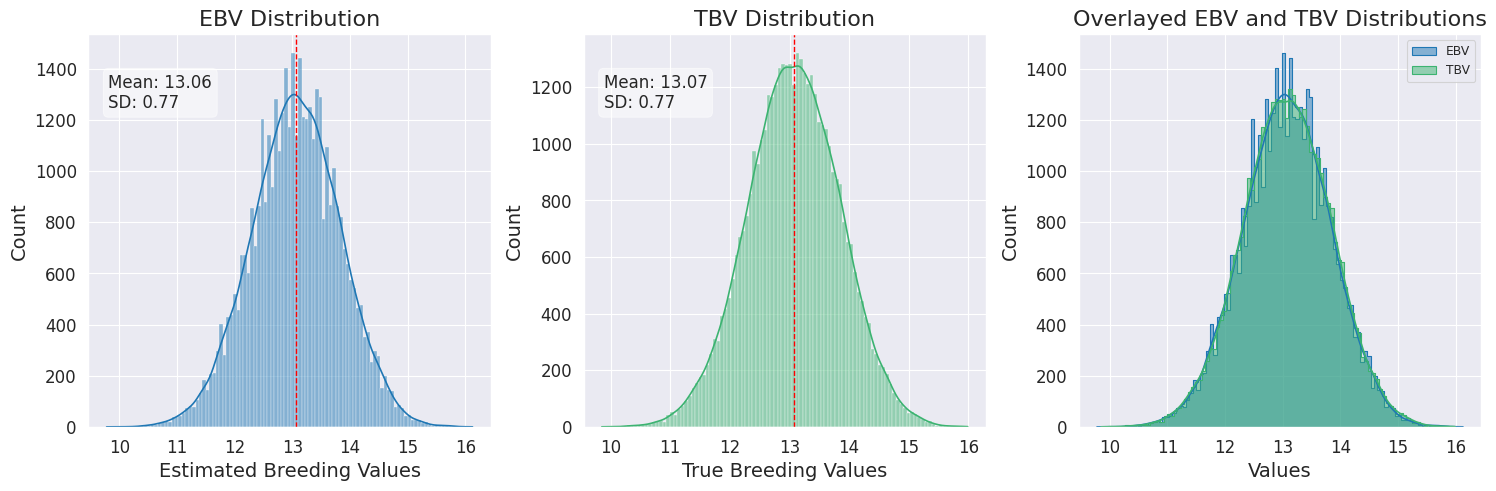

In [23]:
plot_histograms(output_np, targets_np, 'GraphSage')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


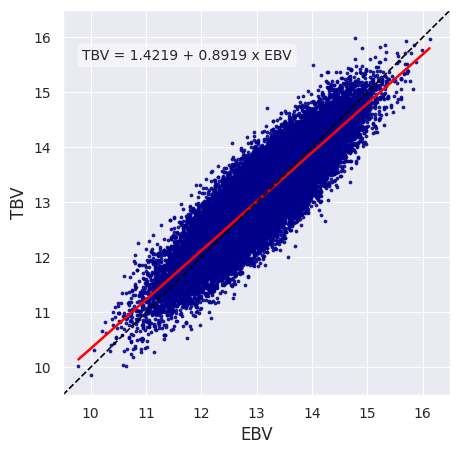

In [22]:
createScatterPlot(inference_df, 'GraphSage')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


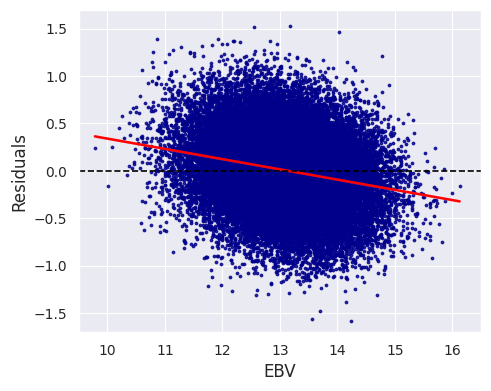

In [25]:
plot_residuals(output_np, targets_np, 'GraphSage')

In [ ]:
plot_wandering_schemantic(output_np, targets_np, 'GraphSage')

In [25]:
calcMetrics(output_np, targets_np)

MSE: 0.1381969507873101
Mean Absolute Error: 0.29624921183359054
R2 Score: 0.7695627851008051
Pearson Correlation Coefficient: 0.8838465868276866
p-value: 0.0
rmse: 0.37174850475463933
mape: 2.274781107777143
mbe: 0.009010131132035028


In [26]:
stratifiedMetrics(output_np, targets_np)


Value Range for Bin 1: 9.853228569030762 - 11.897905985514322
Mean Absolute Error: 0.32059990317229164

Value Range for Bin 2: 11.897905985514322 - 13.942583401997883
Mean Absolute Error: 0.2914006997035204

Value Range for Bin 3: 13.942583401997883 - 15.987260818481445
Mean Absolute Error: 0.3138712049620243


In [106]:
data.x.shape

torch.Size([284992, 26282, 3])

In [107]:
sums = torch.sum(data.x, dim=(1, 2))
zeros_count = torch.sum(sums == 0).item()

In [108]:
sums

tensor([26282., 26282., 26282.,  ..., 26282., 26282., 26282.])

In [109]:
zeros_count

32992

In [45]:
samples_with_zeros = torch.nonzero(data.x.all(dim=1)).squeeze()

In [46]:
samples_with_zeros

tensor([], size=(0, 2), dtype=torch.int64)

In [47]:
data.has_self_loops()

False

In [48]:
has_nans = torch.isnan(data.x).any()

if has_nans:
    print("The tensor contains NaN values.")
else:
    print("The tensor does not contain NaN values.")

The tensor does not contain NaN values.


In [110]:
sums = torch.sum(data.x, dim=(1, 2)) 
zeros_mask = sums == 0 
print(zeros_mask)

tensor([False, False, False,  ..., False, False, False])


In [111]:
zeros_mask.sum()

tensor(32992)

In [112]:
new_tensor = data.node_ids[zeros_mask]
new_tensor

tensor([1048855., 1048899., 1048917.,  ..., 1047927., 1048275., 1048335.],
       dtype=torch.float64)

In [113]:
filtered_df = df_ped[df_ped['id'].isin(new_tensor.numpy())]
filtered_df

,id,sire,dam,generation,sex
517723,517724.0,479651,467718.0,12,F
518153,518154.0,467917,410662.0,12,F
519505,519506.0,467107,502002.0,12,F
527705,527706.0,467917,464338.0,12,F
536063,536064.0,467917,401512.0,12,F
...,...,...,...,...,...
1258758,1258759.0,1183153,1141328.0,29,M
1259422,1259423.0,1180399,1182256.0,29,M
1259434,1259435.0,1210515,1204054.0,29,M
1259664,1259665.0,1215431,1194516.0,29,M


In [114]:
count_F = (filtered_df['sex'] == 'F').sum()
count_M = (filtered_df['sex'] == 'M').sum()

print(f"Count of 'F': {count_F}")
print(f"Count of 'M': {count_M}")

Count of 'F': 30992
Count of 'M': 2000


In [53]:
count_F = (filtered_df['sex'] == 'F').sum()
count_M = (filtered_df['sex'] == 'M').sum()

print(f"Count of 'F': {count_F}")
print(f"Count of 'M': {count_M}")

Count of 'F': 30992
Count of 'M': 200


In [33]:
pedigree_path = dataRoot + heritability + heritability + "_simu.ped"

In [34]:
df_ped = pd.read_csv(pedigree_path, sep=" ", header=None, names=["id", "sire", "dam", "generation", "sex"])

In [35]:
df_ped

,id,sire,dam,generation,sex
0,1.0,0,0.0,0,M
1,2.0,0,0.0,0,M
2,3.0,0,0.0,0,M
3,4.0,0,0.0,0,M
4,5.0,0,0.0,0,M
...,...,...,...,...,...
1302195,1302196.0,1247495,1138222.0,30,F
1302196,1302197.0,1220769,1162800.0,30,M
1302197,1302198.0,1242187,1083544.0,30,F
1302198,1302199.0,1222833,1134422.0,30,M


In [36]:
filtered_df = df_ped[df_ped['id'].isin(new_tensor.numpy())]
filtered_df

,id,sire,dam,generation,sex
619214,619215.0,567721,586838.0,14,M
717622,717623.0,686703,706938.0,17,M
718270,718271.0,692089,676126.0,17,M
721262,721263.0,619215,704822.0,17,M
732664,732665.0,673063,676230.0,17,M
...,...,...,...,...,...
1258758,1258759.0,1183153,1141328.0,29,M
1259422,1259423.0,1180399,1182256.0,29,M
1259434,1259435.0,1210515,1204054.0,29,M
1259664,1259665.0,1215431,1194516.0,29,M


In [37]:
filtered_df['sex'].unique()

array(['M'], dtype=object)

In [38]:
filtered_df = df_ped[df_ped['id'].isin(data.node_ids.numpy())]
filtered_df

,id,sire,dam,generation,sex
517723,517724.0,479651,467718.0,12,F
518153,518154.0,467917,410662.0,12,F
519505,519506.0,467107,502002.0,12,F
527705,527706.0,467917,464338.0,12,F
536063,536064.0,467917,401512.0,12,F
...,...,...,...,...,...
1302195,1302196.0,1247495,1138222.0,30,F
1302196,1302197.0,1220769,1162800.0,30,M
1302197,1302198.0,1242187,1083544.0,30,F
1302198,1302199.0,1222833,1134422.0,30,M


In [39]:
males = filtered_df[filtered_df['sex'] == 'M']
females = filtered_df[filtered_df['sex'] == 'F']

In [40]:
count_F = (filtered_df['sex'] == 'F').sum()
count_M = (filtered_df['sex'] == 'M').sum()

print(f"Count of 'F': {count_F}")
print(f"Count of 'M': {count_M}")

Count of 'F': 261992
Count of 'M': 23000


In [26]:
animal_counts_sorted = filtered_df['generation'].value_counts().sort_index()
print("Counts of each value in the 'generation' column:")
print(animal_counts_sorted)

Counts of each value in the 'generation' column:
generation
12        8
13       71
14      330
15     1167
16     3361
17     6346
18     8814
19    11095
20    21180
21    21180
22    21180
23    21180
24    21180
25    21180
26    21180
27    21180
28    21180
29    21180
30    42000
Name: count, dtype: int64


In [42]:
male_counts_sorted = males['generation'].value_counts().sort_index()
print("Counts of each value in the 'generation' column:")
print(male_counts_sorted)

Counts of each value in the 'generation' column:
generation
14        1
17        5
18       14
19      180
20      180
21      180
22      180
23      180
24      180
25      180
26      180
27      180
28      180
29      180
30    21000
Name: count, dtype: int64


In [43]:
female_counts_sorted = females['generation'].value_counts().sort_index()
print("Counts of each value in the 'generation' column:")
print(female_counts_sorted)

Counts of each value in the 'generation' column:
generation
12        8
13       71
14      329
15     1167
16     3361
17     6341
18     8800
19    10915
20    21000
21    21000
22    21000
23    21000
24    21000
25    21000
26    21000
27    21000
28    21000
29    21000
30    21000
Name: count, dtype: int64


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


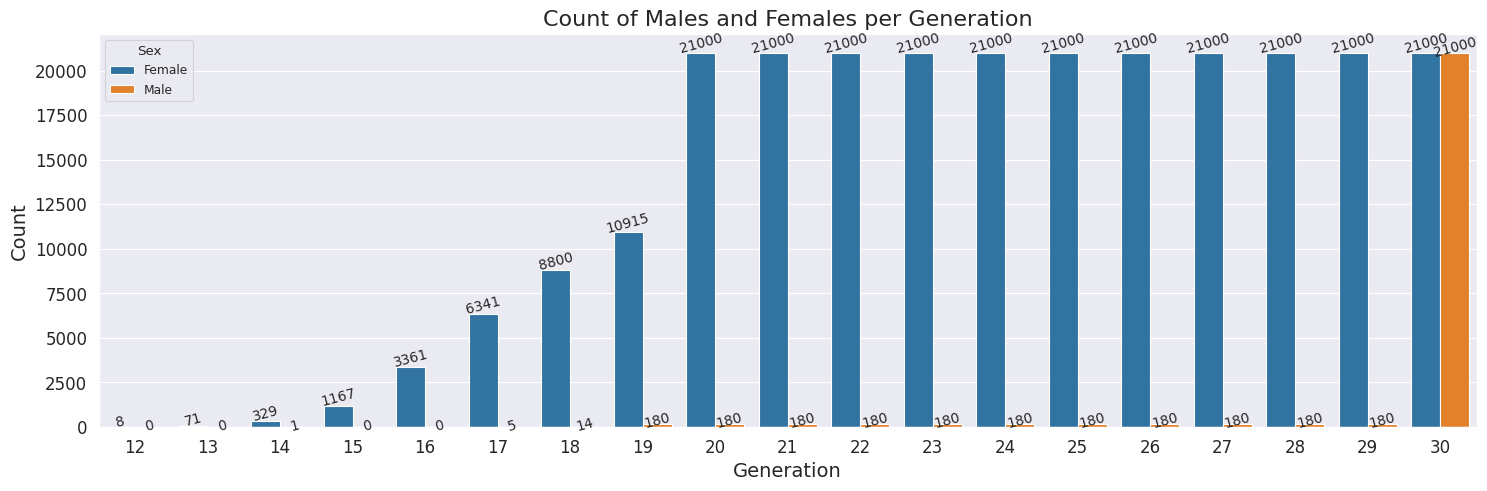

In [45]:
sns.set_style("darkgrid")
sns.set_context("paper")
plt.figure(figsize=(15, 5))

ax = sns.countplot(data=filtered_df, x='generation', hue='sex')
ax.bar_label(ax.containers[0], fontsize=10, rotation = 15, padding = -2);
ax.bar_label(ax.containers[1], fontsize=10, rotation = 15, padding = -5);
plt.tick_params(axis='both', which='major', labelsize=12) 
plt.title('Count of Males and Females per Generation', fontsize=16)
plt.xlabel('Generation', fontsize=14)
plt.ylabel('Count', fontsize=14)
# Changing the legend labels
legend_labels = ['Female','Male']
plt.legend(title='Sex', loc='upper left', labels=legend_labels)

# Show the plots
plt.tight_layout()
plt.savefig('images/nodesPerGen' + '.png')
plt.savefig('images/nodesPerGen' +  '.svg', format='svg', dpi=300)
cairosvg.svg2pdf(url='images/nodesPerGen' + '.svg', write_to='images/nodesPerGen' + '.pdf')
plt.savefig('images/nodesPerGen' + '.eps', format='eps')

plt.show()